In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201, InceptionResNetV2, InceptionV3, MobileNet, MobileNetV2, NASNetLarge, NASNetMobile, ResNet50, ResNet50V2, ResNet101, ResNet101V2, ResNet152, ResNet152V2, VGG16, VGG19, Xception
# from tensorflow.python.lib.io import file_io

import os
import numpy as np
import matplotlib.pyplot as plt

2.1.0


In [2]:
%%bash
pip3 install pillow --user

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
home_dir = os.environ['HOME']
base_dir = os.path.join(home_dir, 'data-vol-1')

In [4]:
######################################################################################################################
# Download the CSV generated by AutoML where images are sorted into TRAIN, VALIDATION and TEST randomly at 80%:10%:10%
# Comment out to save time. Both file_io and gfile fail with local cache.
######################################################################################################################
# csv_file = os.path.join(home_dir, 'data-vol-1/kubeflow/notebooks/idr0042.csv')

# os.system("mkdir -p " + os.path.join(base_dir, 'kubeflow/notebooks'))
# # file_io.copy(oldpath='gs://idr0042/export_data-idr0042-2020-05-06T00:09:20.026Z/image_classification_1.csv', newpath=csv_file, overwrite=True)
# tf.io.gfile.copy(src='gs://idr0042/export_data-idr0042-2020-05-06T00:09:20.026Z/image_classification_1.csv', dst=csv_file, overwrite=True)

# with open(csv_file, 'r') as f:
#     lines = f.readlines()
#     for line in lines:
#         tokens = line.split(',')
#         dataset_name = tokens[0].lower()
#         source = tokens[1]
#         label_name = tokens[2].strip('\n')
#         fname = source.split('/')[-1]

#         os.system("mkdir -p " + os.path.join(base_dir, dataset_name, label_name))
# #         file_io.copy(oldpath=source, newpath=os.path.join(base_dir, dataset_name, label_name, fname), overwrite=True)
#         tf.io.gfile.copy(src=source, dst=os.path.join(base_dir, dataset_name, label_name, fname), overwrite=True)
#         print(line)

In [5]:
#####################
# Understand the data
#####################
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_failure_dir = os.path.join(train_dir, 'chronic_heart_failure')
train_healthy_dir = os.path.join(train_dir, 'not_chronic_heart_failure')
validation_failure_dir = os.path.join(validation_dir, 'chronic_heart_failure')
validation_healthy_dir = os.path.join(validation_dir, 'not_chronic_heart_failure')
test_failure_dir = os.path.join(test_dir, 'chronic_heart_failure')
test_healthy_dir = os.path.join(test_dir, 'not_chronic_heart_failure')

num_failure_tr = len(os.listdir(train_failure_dir))
num_healthy_tr = len(os.listdir(train_healthy_dir))
num_failure_val = len(os.listdir(validation_failure_dir))
num_healthy_val = len(os.listdir(validation_healthy_dir))
num_failure_tst = len(os.listdir(test_failure_dir))
num_healthy_tst = len(os.listdir(test_healthy_dir))

total_train = num_failure_tr + num_healthy_tr
total_val = num_failure_val + num_healthy_val
total_tst = num_failure_tst + num_healthy_tst
total = total_train + total_val + total_tst

print('Total training failure images:', num_failure_tr)
print('Total training healthy images:', num_healthy_tr)
print('Total validation failure images:', num_failure_val)
print('Total validation healthy images:', num_healthy_val)
print('Total test failure images:', num_failure_tst)
print('Total test healthy images:', num_healthy_tst)

print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total test images:", total_tst)
print("Total images:", total)

Total training failure images: 827
Total training healthy images: 755
Total validation failure images: 104
Total validation healthy images: 95
Total test failure images: 103
Total test healthy images: 94
Total training images: 1582
Total validation images: 199
Total test images: 197
Total images: 1978


In [6]:
################################
# Train base models from scratch
################################
# def build(base_model):
#     base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000005, amsgrad=False),
#                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#                   metrics=['accuracy'])
#     base_model.summary()
#     return base_model

In [7]:
############################################
# Train the model with weights of 'imagenet'
############################################
def transfer(base_model, _trainable: bool = True):
    _model = tf.keras.Sequential([
        base_model,

        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1)
    ])
    base_model.trainable = _trainable

#     base_learning_rate = 0.0001
    _model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000005, amsgrad=False),
#         optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy'])

    _model.summary()
    base_model.summary()
    return _model

In [8]:
#################################
# Training and validation history
#################################
def plothistory(_history, name: str = None):
    acc = _history.history['accuracy']
    val_acc = _history.history['val_accuracy']

    loss = _history.history['loss']
    val_loss = _history.history['val_loss']

    plt.figure(figsize=(16, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    plt.title('{} - Training and Validation Accuracy'.format(name))

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, 1.0])
    plt.title('{} - Training and Validation Loss'.format(name))
    plt.xlabel('epoch')
    plt.show()

In [9]:
########################################
# generate data for train and validation
########################################
batch_size = 64     # 128
epochs = 15         # 100
IMG_HEIGHT = 224
IMG_WIDTH = 224

train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1582 images belonging to 2 classes.
Found 199 images belonging to 2 classes.


In [10]:
#################################################################
# Training Keras Application NASNetMobile with weights='imagenet'
#################################################################
model = transfer(NASNetMobile(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 7, 7, 1056)        4269716   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 1056)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9504)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4866560   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 9,136,789
Trainable params: 9,100,051
Non-trainable params: 36,738
_________________________________________________________________
Model: "NASNet"
___________________________________________________________________________________________

normal_concat_9 (Concatenate)   (None, 7, 7, 1056)   0           adjust_bn_9[0][0]                
                                                                 normal_add_1_9[0][0]             
                                                                 normal_add_2_9[0][0]             
                                                                 normal_add_3_9[0][0]             
                                                                 normal_add_4_9[0][0]             
                                                                 normal_add_5_9[0][0]             
__________________________________________________________________________________________________
activation_151 (Activation)     (None, 7, 7, 704)    0           reduction_concat_reduce_8[0][0]  
__________________________________________________________________________________________________
activation_152 (Activation)     (None, 7, 7, 1056)   0           normal_concat_9[0][0]            
__________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 3 steps
Epoch 1/15
24/24 [==============================] - 40s 2s/step - loss: 0.9447 - accuracy: 0.5072 - val_loss: 0.7678 - val_accuracy: 0.5156
Epoch 2/15
24/24 [==============================] - 10s 430ms/step - loss: 0.6108 - accuracy: 0.6660 - val_loss: 0.7374 - val_accuracy: 0.5729
Epoch 3/15
24/24 [==============================] - 10s 429ms/step - loss: 0.4721 - accuracy: 0.7530 - val_loss: 0.7377 - val_accuracy: 0.5625
Epoch 4/15
24/24 [==============================] - 10s 430ms/step - loss: 0.3648 - accuracy: 0.8399 - val_loss: 0.7178 - val_accuracy: 0.5833
Epoch 5/15
24/24 [==============================] - 11s 444ms/step - loss: 0.2913 - accuracy: 0.8874 - val_loss: 0.7218 - val_accuracy: 0.5885
Epoch 6/15
24/24 [==============================] - 10s 426ms/step - loss: 0.2309 - accuracy: 0.9374 - val_loss: 0.7127 - val_accuracy: 0.5885
Epoch 7/15
24/24 [==============================] - 10

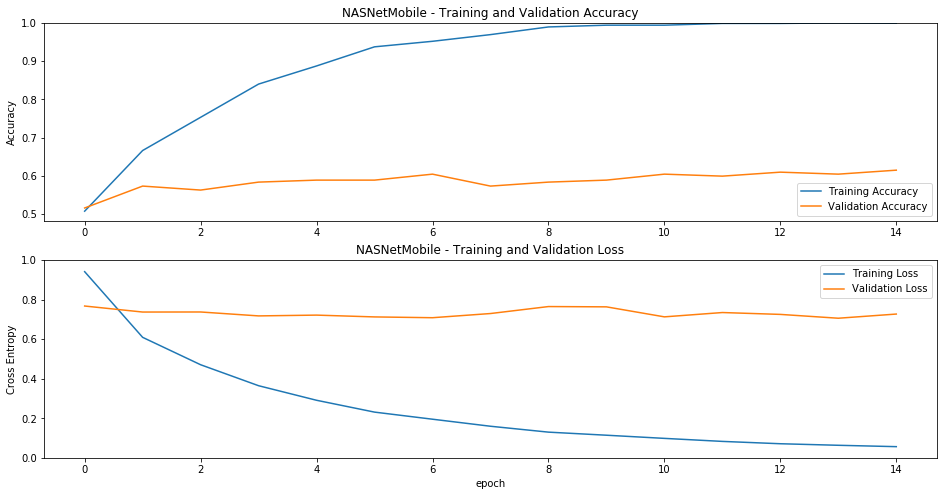

In [11]:
plothistory(history, 'NASNetMobile')

In [12]:
#################################################################
# Training Keras Application NASNetLarge with weights='imagenet' - OOM
#################################################################
# model = transfer(NASNetLarge(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
# history = model.fit(
#     train_data_gen,
#     steps_per_epoch=total_train // batch_size,
#     epochs=epochs,
#     validation_data=val_data_gen,
#     validation_steps=total_val // batch_size
# )

In [13]:
# plothistory(history, 'NASNetLarge')

In [14]:
######################################################################
# Training Keras Application InceptionResNetV2 with weights='imagenet'
######################################################################
model = transfer(InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 1536)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               3146240   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 57,483,489
Trainable params: 57,422,945
Non-trainable params: 60,544
_________________________________________________________________
Model: "inception_resnet_v2"
__________________________________________________________________________

__________________________________________________________________________________________________
activation_390 (Activation)     (None, 5, 5, 256)    0           batch_normalization_202[0][0]    
__________________________________________________________________________________________________
block8_10_mixed (Concatenate)   (None, 5, 5, 448)    0           activation_387[0][0]             
                                                                 activation_390[0][0]             
__________________________________________________________________________________________________
block8_10_conv (Conv2D)         (None, 5, 5, 2080)   933920      block8_10_mixed[0][0]            
__________________________________________________________________________________________________
block8_10 (Lambda)              (None, 5, 5, 2080)   0           block8_9_ac[0][0]                
                                                                 block8_10_conv[0][0]             
__________

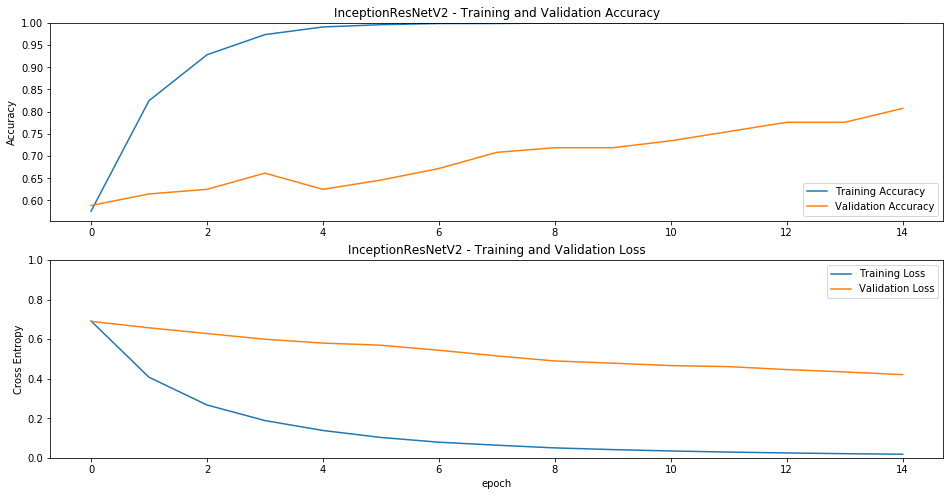

In [15]:
plothistory(history, 'InceptionResNetV2')

In [16]:
#############################################################
# Training Keras Application Xception with weights='imagenet'
#############################################################
model = transfer(Xception(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 30,299,689
Trainable params: 30,245,161
Non-trainable params: 54,528
_________________________________________________________________
Model: "xception"
_____________________________________________________________________________________

  ...
    to  
  ['...']
Train for 24 steps, validate for 3 steps
Epoch 1/15
24/24 [==============================] - 19s 789ms/step - loss: 0.6545 - accuracy: 0.5744 - val_loss: 0.7088 - val_accuracy: 0.5417
Epoch 2/15
24/24 [==============================] - 12s 494ms/step - loss: 0.4678 - accuracy: 0.7530 - val_loss: 0.6629 - val_accuracy: 0.5677
Epoch 3/15
24/24 [==============================] - 12s 494ms/step - loss: 0.3615 - accuracy: 0.8386 - val_loss: 0.6073 - val_accuracy: 0.6406
Epoch 4/15
24/24 [==============================] - 12s 494ms/step - loss: 0.2750 - accuracy: 0.9091 - val_loss: 0.5650 - val_accuracy: 0.6719
Epoch 5/15
24/24 [==============================] - 12s 494ms/step - loss: 0.2066 - accuracy: 0.9486 - val_loss: 0.5118 - val_accuracy: 0.7083
Epoch 6/15
24/24 [==============================] - 12s 492ms/step - loss: 0.1542 - accuracy: 0.9789 - val_loss: 0.4931 - val_accuracy: 0.7083
Epoch 7/15
24/24 [==============================] - 12s 493ms/step - loss: 0

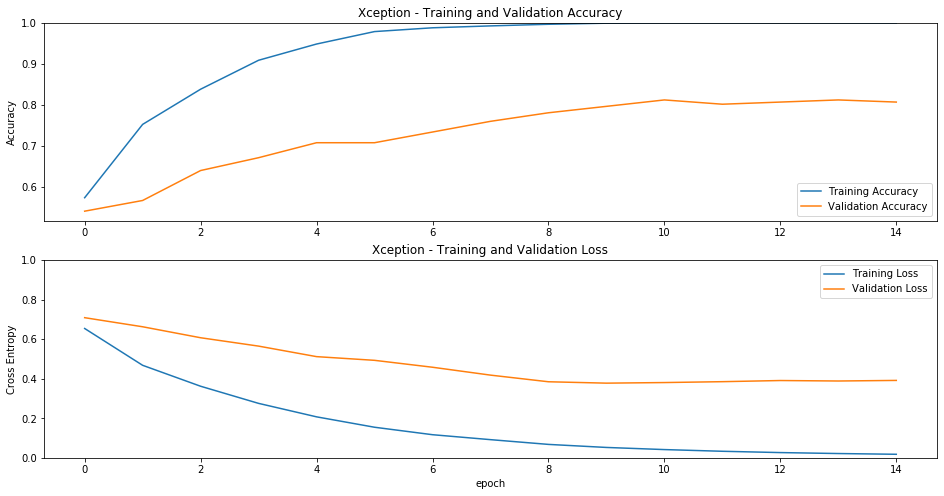

In [17]:
plothistory(history, 'Xception')

In [18]:
################################################################
# Training Keras Application ResNet50 with weights='imagenet'
################################################################
model = transfer(ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 33,025,921
Trainable params: 32,972,801
Non-trainable params: 53,120
_________________________________________________________________
Model: "resnet50"
_____________________________________________________________________________________

  ...
    to  
  ['...']
Train for 24 steps, validate for 3 steps
Epoch 1/15
24/24 [==============================] - 13s 536ms/step - loss: 0.9840 - accuracy: 0.5652 - val_loss: 0.7270 - val_accuracy: 0.5208
Epoch 2/15
24/24 [==============================] - 6s 230ms/step - loss: 0.1895 - accuracy: 0.9249 - val_loss: 0.6952 - val_accuracy: 0.5208
Epoch 3/15
24/24 [==============================] - 5s 229ms/step - loss: 0.0656 - accuracy: 0.9914 - val_loss: 0.7289 - val_accuracy: 0.5208
Epoch 4/15
24/24 [==============================] - 6s 231ms/step - loss: 0.0355 - accuracy: 0.9993 - val_loss: 0.8152 - val_accuracy: 0.4844
Epoch 5/15
24/24 [==============================] - 6s 231ms/step - loss: 0.0251 - accuracy: 1.0000 - val_loss: 1.3696 - val_accuracy: 0.4792
Epoch 6/15
24/24 [==============================] - 6s 233ms/step - loss: 0.0195 - accuracy: 1.0000 - val_loss: 1.1153 - val_accuracy: 0.4792
Epoch 7/15
24/24 [==============================] - 6s 231ms/step - loss: 0.0154 

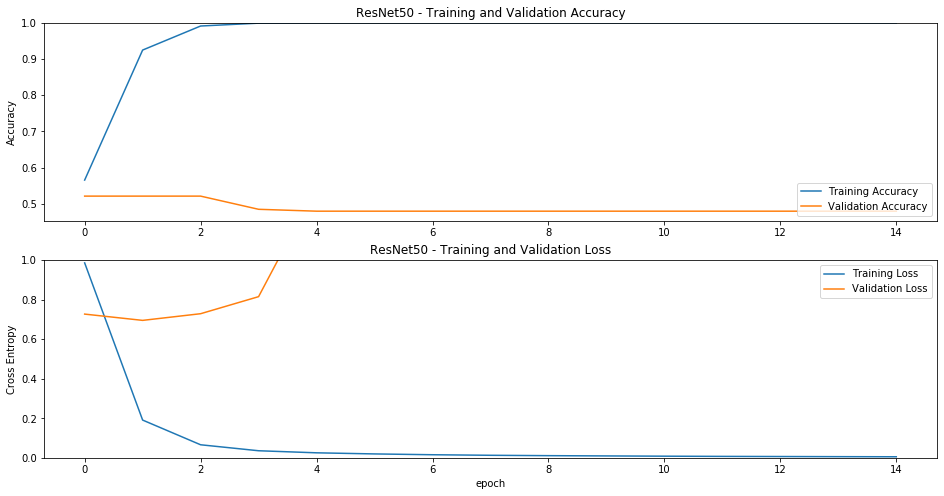

In [19]:
plothistory(history, 'ResNet50')

In [20]:
################################################################
# Training Keras Application ResNet101 with weights='imagenet'
################################################################
model = transfer(ResNet101(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 7, 7, 2048)        42658176  
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 52,096,385
Trainable params: 51,991,041
Non-trainable params: 105,344
_________________________________________________________________
Model: "resnet101"
___________________________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 3 steps
Epoch 1/15
24/24 [==============================] - 20s 832ms/step - loss: 0.8535 - accuracy: 0.6199 - val_loss: 0.9206 - val_accuracy: 0.5208
Epoch 2/15
24/24 [==============================] - 9s 363ms/step - loss: 0.1695 - accuracy: 0.9368 - val_loss: 0.8302 - val_accuracy: 0.5156
Epoch 3/15
24/24 [==============================] - 9s 368ms/step - loss: 0.0441 - accuracy: 0.9974 - val_loss: 0.7655 - val_accuracy: 0.4844
Epoch 4/15
24/24 [==============================] - 9s 365ms/step - loss: 0.0243 - accuracy: 1.0000 - val_loss: 2.7426 - val_accuracy: 0.4792
Epoch 5/15
24/24 [==============================] - 9s 364ms/step - loss: 0.0175 - accuracy: 1.0000 - val_loss: 4.9088 - val_accuracy: 0.4792
Epoch 6/15
24/24 [==============================] - 9s 365ms/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 6.0234 - val_accuracy: 0.4792
Epoch 7/15
24/24 [==============================] - 9s 3

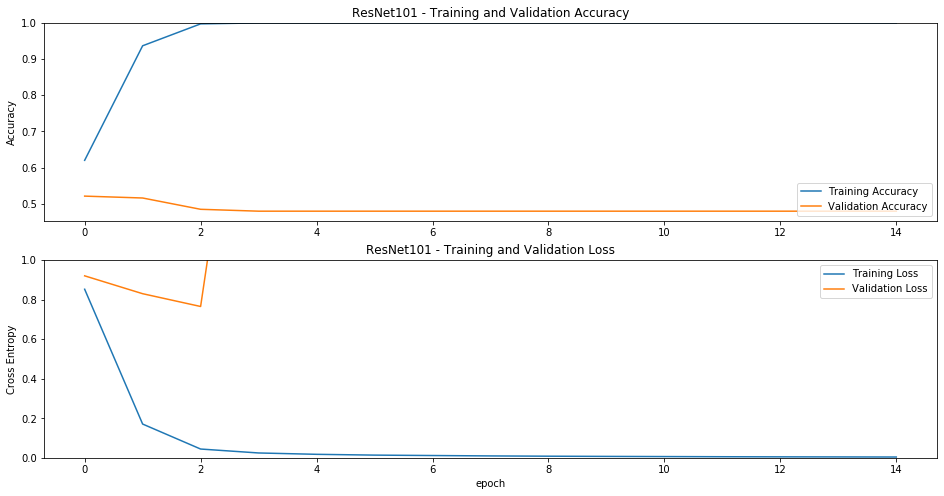

In [21]:
plothistory(history, 'ResNet101')

In [22]:
################################################################
# Training Keras Application ResNet152 with weights='imagenet'
################################################################
model = transfer(ResNet152(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Model)            (None, 7, 7, 2048)        58370944  
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               9437696   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 67,809,153
Trainable params: 67,657,729
Non-trainable params: 151,424
_________________________________________________________________
Model: "resnet152"
___________________________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 3 steps
Epoch 1/15
24/24 [==============================] - 30s 1s/step - loss: 0.9114 - accuracy: 0.5817 - val_loss: 0.8982 - val_accuracy: 0.4792
Epoch 2/15
24/24 [==============================] - 12s 509ms/step - loss: 0.0996 - accuracy: 0.9684 - val_loss: 0.7771 - val_accuracy: 0.4948
Epoch 3/15
24/24 [==============================] - 12s 510ms/step - loss: 0.0284 - accuracy: 1.0000 - val_loss: 0.9525 - val_accuracy: 0.5208
Epoch 4/15
24/24 [==============================] - 12s 509ms/step - loss: 0.0172 - accuracy: 1.0000 - val_loss: 0.9952 - val_accuracy: 0.5208
Epoch 5/15
24/24 [==============================] - 12s 509ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 1.7113 - val_accuracy: 0.5208
Epoch 6/15
24/24 [==============================] - 12s 511ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 2.2003 - val_accuracy: 0.5208
Epoch 7/15
24/24 [==============================] - 12

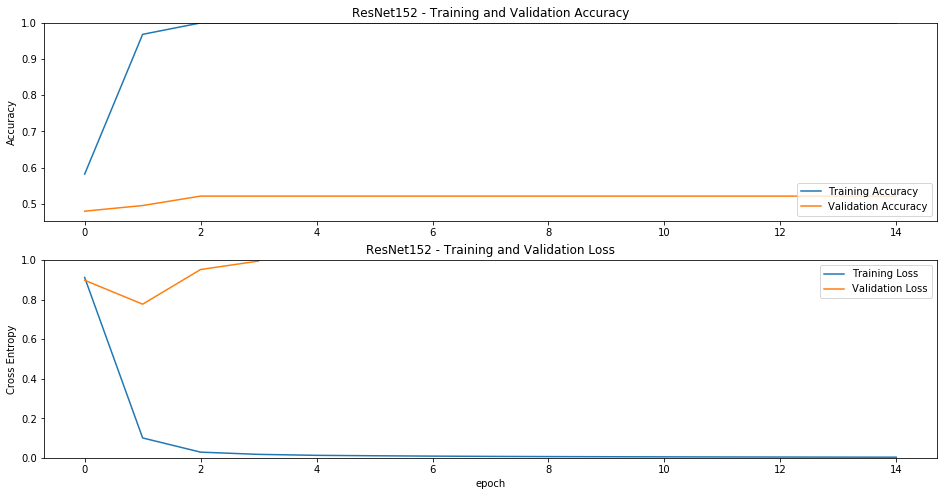

In [23]:
plothistory(history, 'ResNet152')

In [24]:
################################################################
# Training Keras Application ResNet50V2 with weights='imagenet'
################################################################
model = transfer(ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               9437696   
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 33,003,009
Trainable params: 32,957,569
Non-trainable params: 45,440
_________________________________________________________________
Model: "resnet50v2"
___________________________________________________________________________________

  ...
    to  
  ['...']
Train for 24 steps, validate for 3 steps
Epoch 1/15
24/24 [==============================] - 11s 477ms/step - loss: 1.1316 - accuracy: 0.5441 - val_loss: 0.8030 - val_accuracy: 0.6198
Epoch 2/15
24/24 [==============================] - 5s 209ms/step - loss: 0.1861 - accuracy: 0.9374 - val_loss: 0.8367 - val_accuracy: 0.6094
Epoch 3/15
24/24 [==============================] - 5s 209ms/step - loss: 0.0568 - accuracy: 0.9941 - val_loss: 0.9249 - val_accuracy: 0.5781
Epoch 4/15
24/24 [==============================] - 5s 210ms/step - loss: 0.0257 - accuracy: 1.0000 - val_loss: 0.9761 - val_accuracy: 0.5938
Epoch 5/15
24/24 [==============================] - 5s 211ms/step - loss: 0.0188 - accuracy: 1.0000 - val_loss: 0.9304 - val_accuracy: 0.5938
Epoch 6/15
24/24 [==============================] - 5s 210ms/step - loss: 0.0151 - accuracy: 1.0000 - val_loss: 0.9265 - val_accuracy: 0.5781
Epoch 7/15
24/24 [==============================] - 5s 210ms/step - loss: 0.0127 

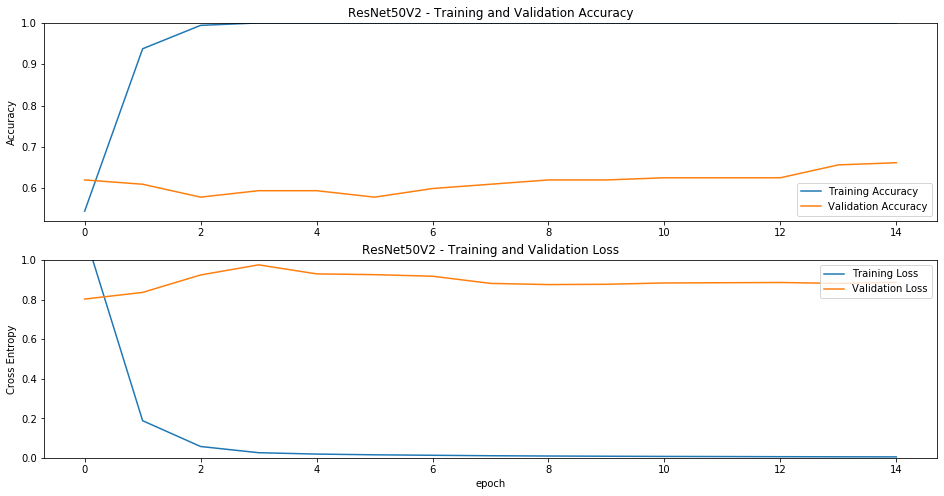

In [25]:
plothistory(history, 'ResNet50V2')

In [26]:
################################################################
# Training Keras Application ResNet101V2 with weights='imagenet'
################################################################
model = transfer(ResNet101V2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Model)          (None, 7, 7, 2048)        42626560  
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               9437696   
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 513       
Total params: 52,064,769
Trainable params: 51,967,105
Non-trainable params: 97,664
_________________________________________________________________
Model: "resnet101v2"
__________________________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 3 steps
Epoch 1/15
24/24 [==============================] - 19s 782ms/step - loss: 1.0886 - accuracy: 0.5329 - val_loss: 1.0121 - val_accuracy: 0.5156
Epoch 2/15
24/24 [==============================] - 8s 339ms/step - loss: 0.1070 - accuracy: 0.9723 - val_loss: 1.0362 - val_accuracy: 0.5469
Epoch 3/15
24/24 [==============================] - 8s 340ms/step - loss: 0.0260 - accuracy: 0.9980 - val_loss: 0.9701 - val_accuracy: 0.6042
Epoch 4/15
24/24 [==============================] - 8s 339ms/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 0.9829 - val_accuracy: 0.5885
Epoch 5/15
24/24 [==============================] - 8s 340ms/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 1.0086 - val_accuracy: 0.5885
Epoch 6/15
24/24 [==============================] - 8s 340ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.9974 - val_accuracy: 0.5990
Epoch 7/15
24/24 [==============================] - 8s 3

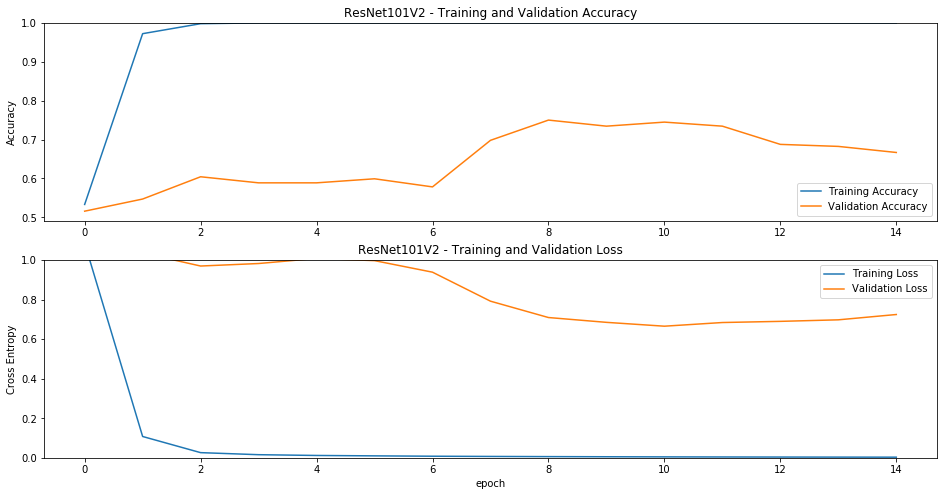

In [27]:
plothistory(history, 'ResNet101V2')

In [28]:
################################################################
# Training Keras Application ResNet152V2 with weights='imagenet' - OOM
################################################################
# model = transfer(ResNet152V2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
# history = model.fit(
#     train_data_gen,
#     steps_per_epoch=total_train // batch_size,
#     epochs=epochs,
#     validation_data=val_data_gen,
#     validation_steps=total_val // batch_size
# )

In [29]:
# plothistory(history, 'ResNet152V2')

In [30]:
################################################################
# Training Keras Application DenseNet121 with weights='imagenet'
################################################################
model = transfer(DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 3, 3, 1024)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               4719104   
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 513       
Total params: 11,757,121
Trainable params: 11,673,473
Non-trainable params: 83,648
_________________________________________________________________
Model: "densenet121"
__________________________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 3 steps
Epoch 1/15
24/24 [==============================] - 21s 885ms/step - loss: 0.8488 - accuracy: 0.5731 - val_loss: 0.6920 - val_accuracy: 0.5990
Epoch 2/15
24/24 [==============================] - 6s 241ms/step - loss: 0.4446 - accuracy: 0.7826 - val_loss: 0.6777 - val_accuracy: 0.6146
Epoch 3/15
24/24 [==============================] - 6s 240ms/step - loss: 0.2874 - accuracy: 0.8808 - val_loss: 0.6681 - val_accuracy: 0.6510
Epoch 4/15
24/24 [==============================] - 6s 241ms/step - loss: 0.1831 - accuracy: 0.9539 - val_loss: 0.6600 - val_accuracy: 0.6771
Epoch 5/15
24/24 [==============================] - 6s 240ms/step - loss: 0.1263 - accuracy: 0.9789 - val_loss: 0.6517 - val_accuracy: 0.7135
Epoch 6/15
24/24 [==============================] - 6s 241ms/step - loss: 0.0950 - accuracy: 0.9947 - val_loss: 0.6308 - val_accuracy: 0.7135
Epoch 7/15
24/24 [==============================] - 6s 2

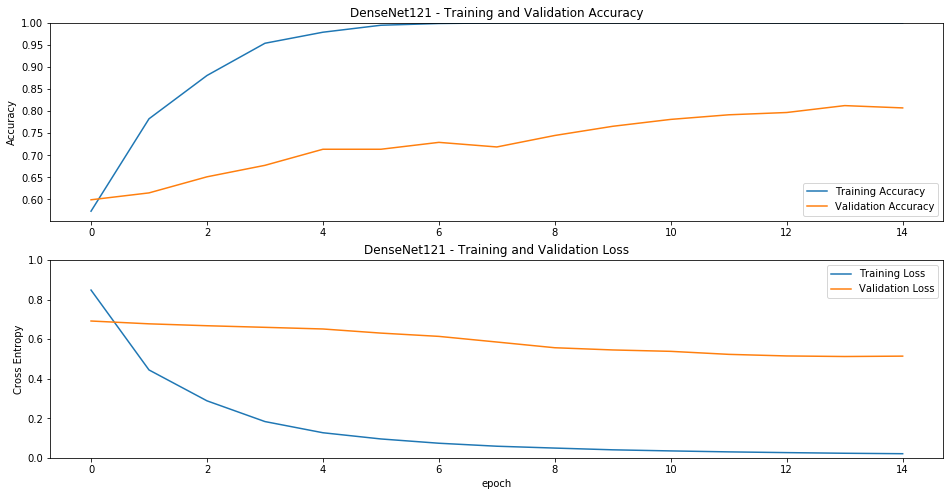

In [31]:
plothistory(history, 'DenseNet121')

In [32]:
################################################################
# Training Keras Application DenseNet169 with weights='imagenet'
################################################################
model = transfer(DenseNet169(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 7, 7, 1664)        12642880  
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 3, 3, 1664)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 14976)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               7668224   
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 513       
Total params: 20,311,617
Trainable params: 20,153,217
Non-trainable params: 158,400
_________________________________________________________________
Model: "densenet169"
_________________________________________________________________________________

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 3 steps
Epoch 1/15
24/24 [==============================] - 26s 1s/step - loss: 0.7894 - accuracy: 0.5883 - val_loss: 0.7257 - val_accuracy: 0.5365
Epoch 2/15
24/24 [==============================] - 7s 290ms/step - loss: 0.3460 - accuracy: 0.8570 - val_loss: 0.6920 - val_accuracy: 0.6094
Epoch 3/15
24/24 [==============================] - 7s 290ms/step - loss: 0.1866 - accuracy: 0.9513 - val_loss: 0.6847 - val_accuracy: 0.6667
Epoch 4/15
24/24 [==============================] - 7s 291ms/step - loss: 0.1202 - accuracy: 0.9868 - val_loss: 0.6569 - val_accuracy: 0.6927
Epoch 5/15
24/24 [==============================] - 7s 292ms/step - loss: 0.0842 - accuracy: 0.9960 - val_loss: 0.6332 - val_accuracy: 0.6667
Epoch 6/15
24/24 [==============================] - 7s 290ms/step - loss: 0.0618 - accuracy: 1.0000 - val_loss: 0.5908 - val_accuracy: 0.6823
Epoch 7/15
24/24 [==============================] - 7s 291m

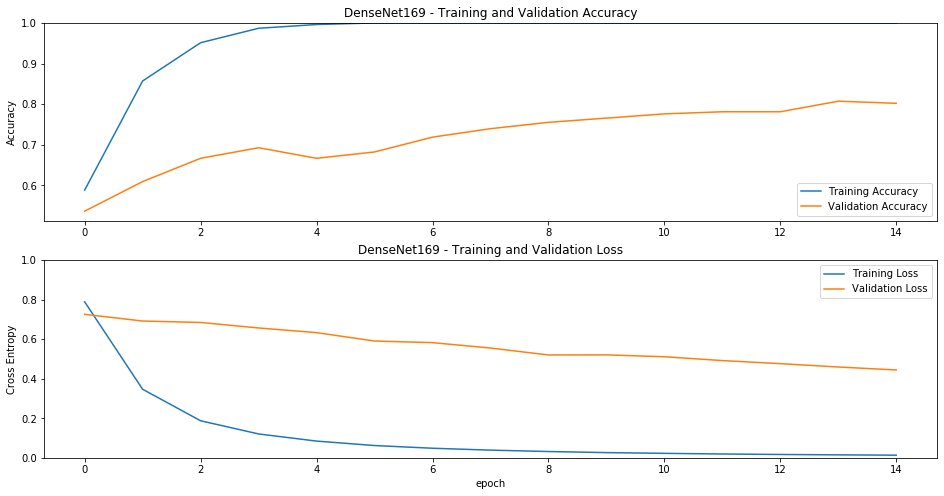

In [33]:
plothistory(history, 'DenseNet169')

In [34]:
################################################################
# Training Keras Application DenseNet201 with weights='imagenet' - OOM
################################################################
# model = transfer(DenseNet201(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
# history = model.fit(
#     train_data_gen,
#     steps_per_epoch=total_train // batch_size,
#     epochs=epochs,
#     validation_data=val_data_gen,
#     validation_steps=total_val // batch_size
# )

In [35]:
# plothistory(history, 'DenseNet201')

In [36]:
##########################################################
# Training Keras Application VGG16 with weights='imagenet'
##########################################################
model = transfer(VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               2359808   
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 513       
Total params: 17,075,009
Trainable params: 17,075,009
Non-trainable params: 0
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)              

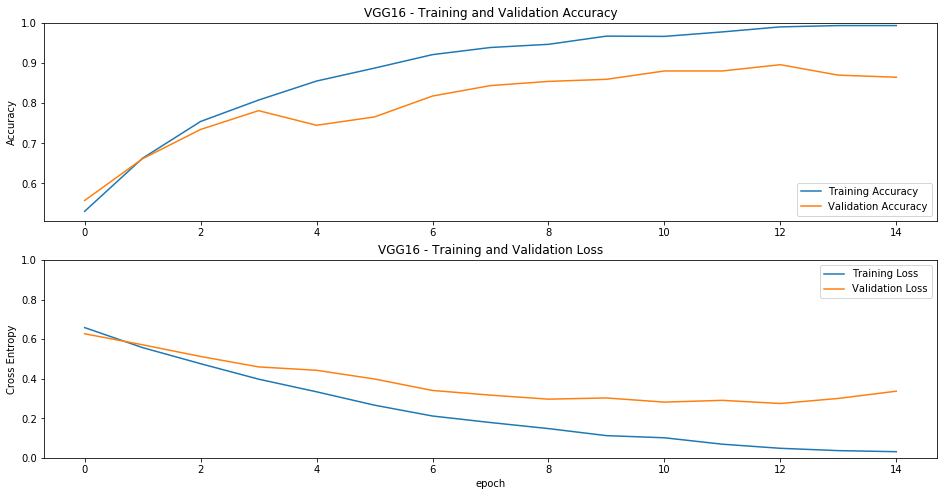

In [37]:
plothistory(history, 'VGG16')

In [38]:
##########################################################
# Training Keras Application VGG19 with weights='imagenet'
##########################################################
model = transfer(VGG19(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               2359808   
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 513       
Total params: 22,384,705
Trainable params: 22,384,705
Non-trainable params: 0
_________________________________________________________________
Model: "vgg19"
_________________________________________________________________
Layer (type)              

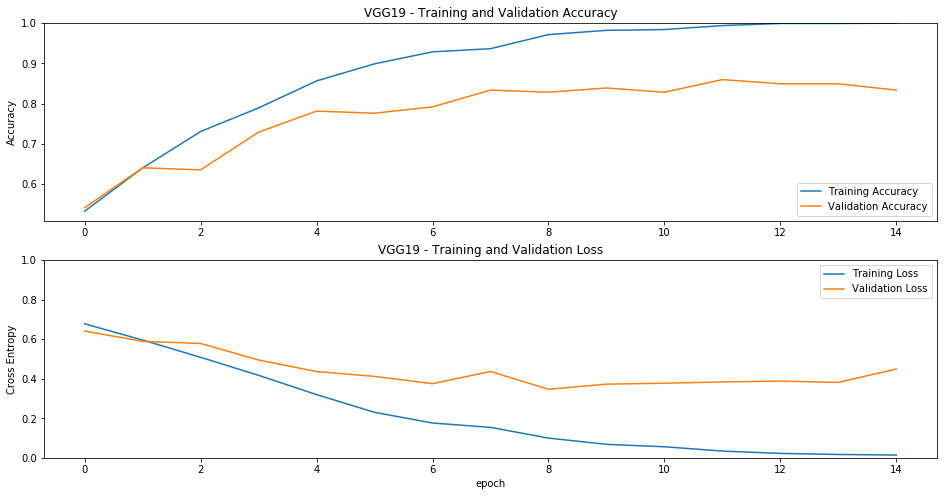

In [39]:
plothistory(history, 'VGG19')

In [40]:
################################################################
# Training Keras Application InceptionV3 with weights='imagenet'
################################################################
model = transfer(InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 513       
Total params: 25,998,113
Trainable params: 25,963,681
Non-trainable params: 34,432
_________________________________________________________________
Model: "inception_v3"
________________________________________________________________________________

  ...
    to  
  ['...']
Train for 24 steps, validate for 3 steps
Epoch 1/15
24/24 [==============================] - 13s 544ms/step - loss: 0.7736 - accuracy: 0.5267 - val_loss: 0.8242 - val_accuracy: 0.4896
Epoch 2/15
24/24 [==============================] - 5s 220ms/step - loss: 0.3581 - accuracy: 0.8788 - val_loss: 0.7945 - val_accuracy: 0.4896
Epoch 3/15
24/24 [==============================] - 4s 186ms/step - loss: 0.2125 - accuracy: 0.9611 - val_loss: 0.7476 - val_accuracy: 0.5729
Epoch 4/15
24/24 [==============================] - 4s 185ms/step - loss: 0.1377 - accuracy: 0.9901 - val_loss: 0.6886 - val_accuracy: 0.6302
Epoch 5/15
24/24 [==============================] - 4s 184ms/step - loss: 0.0980 - accuracy: 0.9987 - val_loss: 0.6432 - val_accuracy: 0.6667
Epoch 6/15
24/24 [==============================] - 4s 184ms/step - loss: 0.0710 - accuracy: 1.0000 - val_loss: 0.6571 - val_accuracy: 0.5833
Epoch 7/15
24/24 [==============================] - 4s 182ms/step - loss: 0.0556 

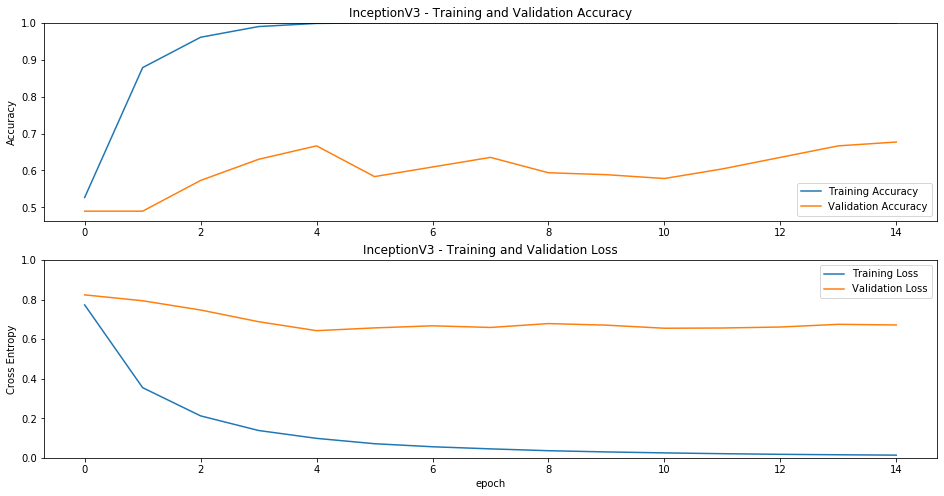

In [41]:
plothistory(history, 'InceptionV3')

In [42]:
########################################
# Training Keras Application MobileNet
########################################
model = transfer(MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 3, 3, 1024)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 9216)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               4719104   
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 513       
Total params: 7,948,481
Trainable params: 7,926,593
Non-trainable params: 21,888
_________________________________________________________________
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (typ

  ...
    to  
  ['...']
Train for 24 steps, validate for 3 steps
Epoch 1/15
24/24 [==============================] - 8s 347ms/step - loss: 1.0684 - accuracy: 0.5659 - val_loss: 0.8480 - val_accuracy: 0.5521
Epoch 2/15
24/24 [==============================] - 5s 225ms/step - loss: 0.5663 - accuracy: 0.7365 - val_loss: 0.8024 - val_accuracy: 0.6094
Epoch 3/15
24/24 [==============================] - 6s 232ms/step - loss: 0.3450 - accuracy: 0.8509 - val_loss: 0.7799 - val_accuracy: 0.6042
Epoch 4/15
24/24 [==============================] - 6s 230ms/step - loss: 0.2167 - accuracy: 0.9308 - val_loss: 0.7558 - val_accuracy: 0.6250
Epoch 5/15
24/24 [==============================] - 6s 230ms/step - loss: 0.1489 - accuracy: 0.9717 - val_loss: 0.7722 - val_accuracy: 0.6354
Epoch 6/15
24/24 [==============================] - 5s 229ms/step - loss: 0.0989 - accuracy: 0.9901 - val_loss: 0.7814 - val_accuracy: 0.6771
Epoch 7/15
24/24 [==============================] - 5s 227ms/step - loss: 0.0762 -

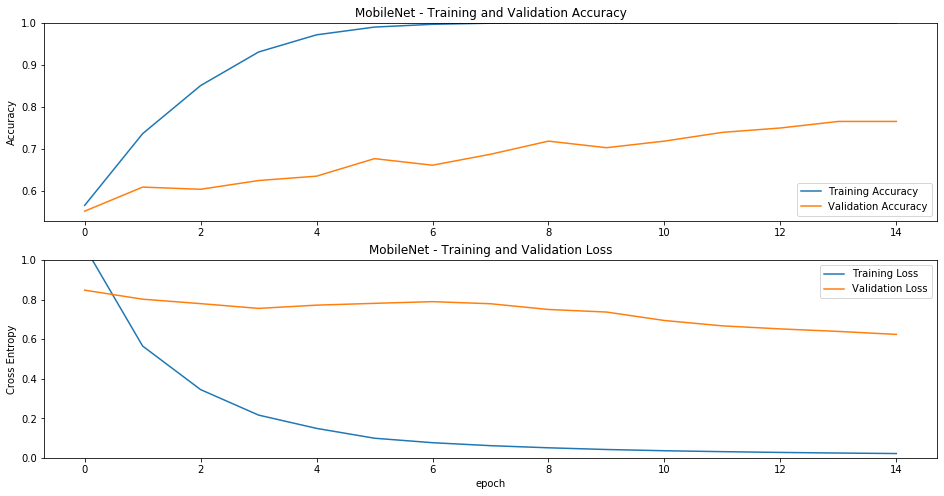

In [43]:
plothistory(history, 'MobileNet')

In [44]:
########################################
# Training Keras Application MobileNetV2
########################################
model = transfer(MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 3, 3, 1280)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 11520)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)               5898752   
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 513       
Total params: 8,157,249
Trainable params: 8,123,137
Non-trainable params: 34,112
_________________________________________________________________
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________

  ...
    to  
  ['...']
Train for 24 steps, validate for 3 steps
Epoch 1/15
24/24 [==============================] - 11s 472ms/step - loss: 0.9136 - accuracy: 0.5771 - val_loss: 0.9930 - val_accuracy: 0.5104
Epoch 2/15
24/24 [==============================] - 6s 244ms/step - loss: 0.4423 - accuracy: 0.8011 - val_loss: 0.8705 - val_accuracy: 0.5625
Epoch 3/15
24/24 [==============================] - 6s 240ms/step - loss: 0.2558 - accuracy: 0.9051 - val_loss: 0.8244 - val_accuracy: 0.5469
Epoch 4/15
24/24 [==============================] - 6s 240ms/step - loss: 0.1654 - accuracy: 0.9552 - val_loss: 0.7846 - val_accuracy: 0.5677
Epoch 5/15
24/24 [==============================] - 6s 243ms/step - loss: 0.1091 - accuracy: 0.9868 - val_loss: 0.7628 - val_accuracy: 0.5625
Epoch 6/15
24/24 [==============================] - 6s 241ms/step - loss: 0.0802 - accuracy: 0.9960 - val_loss: 0.7415 - val_accuracy: 0.5938
Epoch 7/15
24/24 [==============================] - 6s 240ms/step - loss: 0.0616 

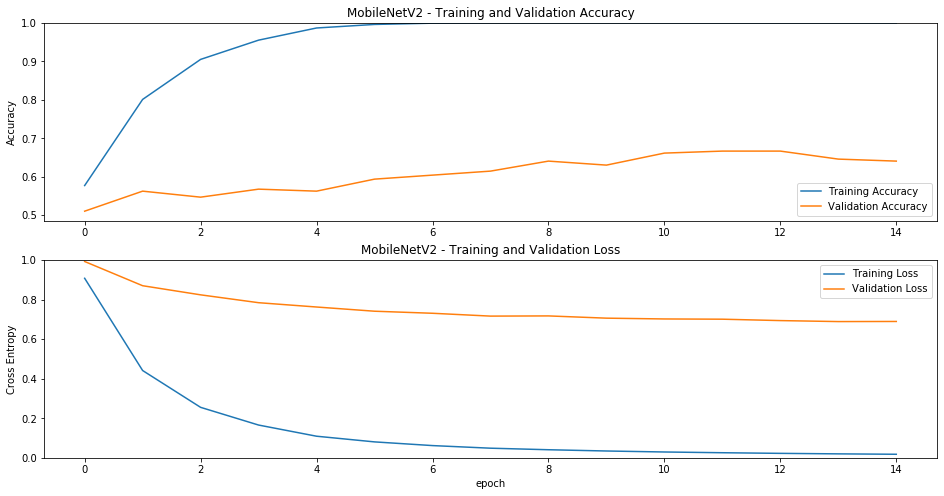

In [45]:
plothistory(history, 'MobileNetV2')

In [46]:
######################################################################################################################
# epochs = 15         # 100

In [47]:
########################################
# Training Keras Application NASNetMobile
########################################
# model = build(NASNetMobile(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights=None, classes=1))
model = transfer(NASNetMobile(weights=None, include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Model)               (None, 7, 7, 1056)        4269716   
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 3, 3, 1056)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 9504)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 512)               4866560   
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 513       
Total params: 9,136,789
Trainable params: 9,100,051
Non-trainable params: 36,738
_________________________________________________________________
Model: "NASNet"
________________________________________________________________________________________

separable_conv_2_bn_normal_left (None, 7, 7, 176)    704         separable_conv_2_normal_left5_12[
__________________________________________________________________________________________________
normal_add_1_12 (Add)           (None, 7, 7, 176)    0           separable_conv_2_bn_normal_left1_
                                                                 separable_conv_2_bn_normal_right1
__________________________________________________________________________________________________
normal_add_2_12 (Add)           (None, 7, 7, 176)    0           separable_conv_2_bn_normal_left2_
                                                                 separable_conv_2_bn_normal_right2
__________________________________________________________________________________________________
normal_add_3_12 (Add)           (None, 7, 7, 176)    0           normal_left3_12[0][0]            
                                                                 adjust_bn_12[0][0]               
__________

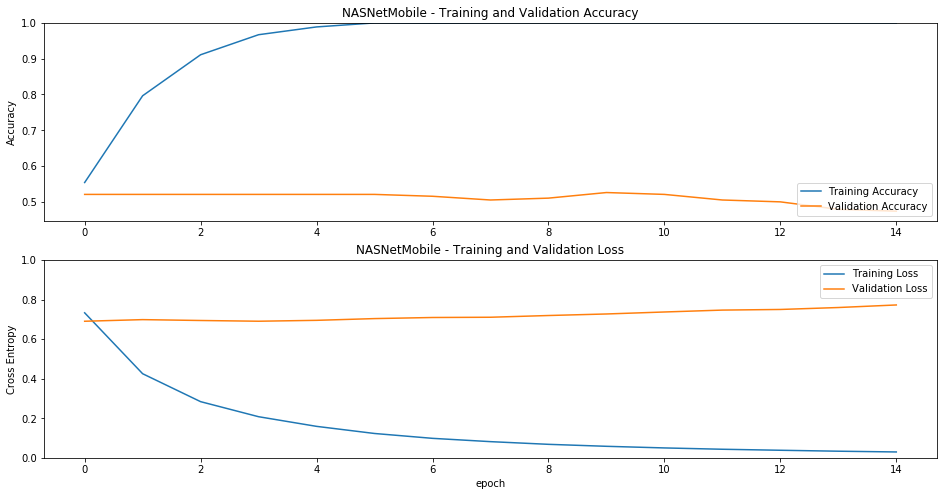

In [48]:
plothistory(history, 'NASNetMobile')

In [49]:
########################################
# Training Keras Application NASNetLarge - OOM
########################################
# # model = build(NASNetLarge(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights=None, classes=1))
# model = transfer(NASNetLarge(weights=None, include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
# history = model.fit(
#     train_data_gen,
#     steps_per_epoch=total_train // batch_size,
#     epochs=epochs,
#     validation_data=val_data_gen,
#     validation_steps=total_val // batch_size
# )

In [50]:
# plothistory(history, 'NASNetLarge')

In [51]:
##############################################
# Training Keras Application InceptionResNetV2
##############################################
# model = build(InceptionResNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights=None, classes=1))
model = transfer(InceptionResNetV2(weights=None, include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 2, 2, 1536)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 6144)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 512)               3146240   
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 513       
Total params: 57,483,489
Trainable params: 57,422,945
Non-trainable params: 60,544
_________________________________________________________________
Model: "inception_resnet_v2"
_________________________________________________________________________

batch_normalization_486 (BatchN (None, 5, 5, 224)    672         conv2d_486[0][0]                 
__________________________________________________________________________________________________
activation_858 (Activation)     (None, 5, 5, 224)    0           batch_normalization_486[0][0]    
__________________________________________________________________________________________________
conv2d_484 (Conv2D)             (None, 5, 5, 192)    399360      block8_5_ac[0][0]                
__________________________________________________________________________________________________
conv2d_487 (Conv2D)             (None, 5, 5, 256)    172032      activation_858[0][0]             
__________________________________________________________________________________________________
batch_normalization_484 (BatchN (None, 5, 5, 192)    576         conv2d_484[0][0]                 
__________________________________________________________________________________________________
batch_norm

  ...
    to  
  ['...']
Train for 24 steps, validate for 3 steps
Epoch 1/15
24/24 [==============================] - 30s 1s/step - loss: 0.6553 - accuracy: 0.6225 - val_loss: 0.6928 - val_accuracy: 0.5208
Epoch 2/15
24/24 [==============================] - 9s 384ms/step - loss: 0.3347 - accuracy: 0.8643 - val_loss: 0.6997 - val_accuracy: 0.5208
Epoch 3/15
24/24 [==============================] - 9s 388ms/step - loss: 0.2024 - accuracy: 0.9677 - val_loss: 0.7126 - val_accuracy: 0.5208
Epoch 4/15
24/24 [==============================] - 9s 389ms/step - loss: 0.1350 - accuracy: 0.9921 - val_loss: 0.7238 - val_accuracy: 0.5208
Epoch 5/15
24/24 [==============================] - 9s 386ms/step - loss: 0.0971 - accuracy: 0.9980 - val_loss: 0.7340 - val_accuracy: 0.5625
Epoch 6/15
24/24 [==============================] - 9s 386ms/step - loss: 0.0735 - accuracy: 0.9993 - val_loss: 0.7489 - val_accuracy: 0.4792
Epoch 7/15
24/24 [==============================] - 9s 388ms/step - loss: 0.0580 - a

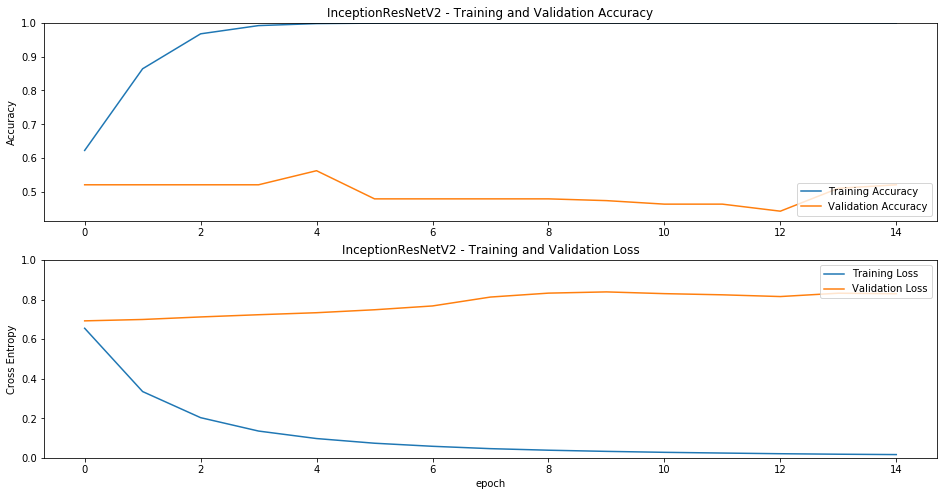

In [52]:
plothistory(history, 'InceptionResNetV2')

In [53]:
#####################################
# Training Keras Application Xception
#####################################
# model = build(Xception(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights=None, classes=1))
model = transfer(Xception(weights=None, include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 18432)             0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               9437696   
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 513       
Total params: 30,299,689
Trainable params: 30,245,161
Non-trainable params: 54,528
_________________________________________________________________
Model: "xception"
____________________________________________________________________________________

  ...
    to  
  ['...']
Train for 24 steps, validate for 3 steps
Epoch 1/15
24/24 [==============================] - 16s 678ms/step - loss: 0.7173 - accuracy: 0.5283 - val_loss: 0.6931 - val_accuracy: 0.5208
Epoch 2/15
24/24 [==============================] - 12s 495ms/step - loss: 0.5350 - accuracy: 0.7088 - val_loss: 0.6931 - val_accuracy: 0.5208
Epoch 3/15
24/24 [==============================] - 12s 495ms/step - loss: 0.4184 - accuracy: 0.8261 - val_loss: 0.6930 - val_accuracy: 0.5208
Epoch 4/15
24/24 [==============================] - 12s 494ms/step - loss: 0.3410 - accuracy: 0.8887 - val_loss: 0.6930 - val_accuracy: 0.5208
Epoch 5/15
24/24 [==============================] - 12s 495ms/step - loss: 0.2723 - accuracy: 0.9499 - val_loss: 0.6928 - val_accuracy: 0.5208
Epoch 6/15
24/24 [==============================] - 12s 495ms/step - loss: 0.2180 - accuracy: 0.9750 - val_loss: 0.6927 - val_accuracy: 0.5208
Epoch 7/15
24/24 [==============================] - 12s 495ms/step - loss: 0

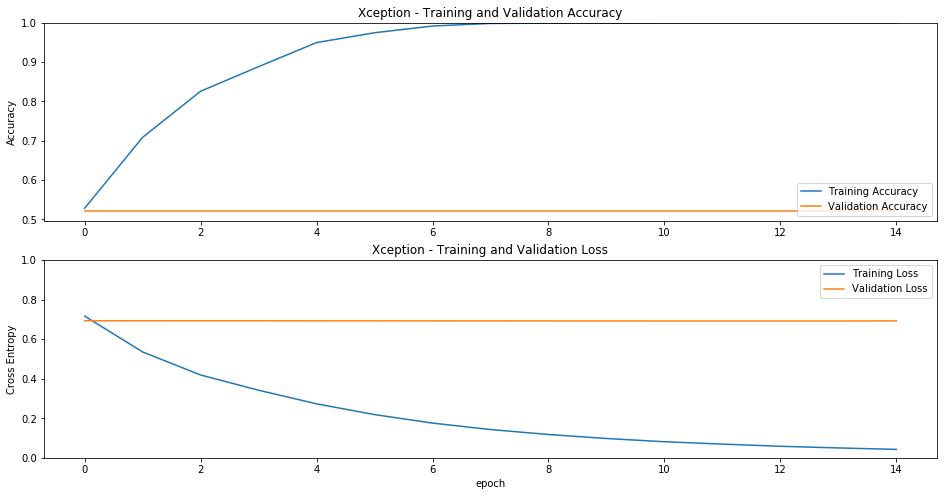

In [54]:
plothistory(history, 'Xception')

In [55]:
########################################
# Training Keras Application ResNet152V2 - OOM
########################################
# model = build(ResNet152V2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights=None, classes=1))
# model = transfer(ResNet152V2(weights=None, include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
# history = model.fit(
#     train_data_gen,
#     steps_per_epoch=total_train // batch_size,
#     epochs=epochs,
#     validation_data=val_data_gen,
#     validation_steps=total_val // batch_size
# )

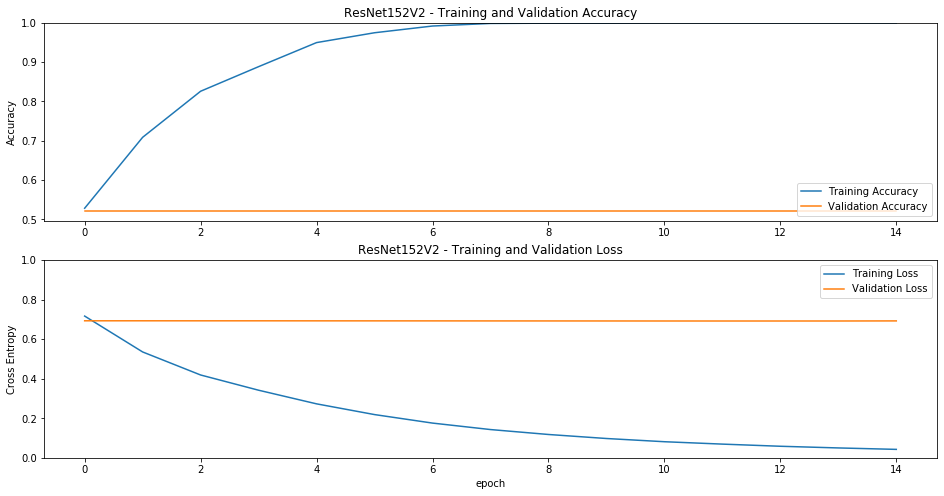

In [56]:
plothistory(history, 'ResNet152V2')

In [57]:
########################################
# Training Keras Application DenseNet201 - OOM
########################################
# # model = build(DenseNet201(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights=None, classes=1))
# model = transfer(DenseNet201(weights=None, include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
# history = model.fit(
#     train_data_gen,
#     steps_per_epoch=total_train // batch_size,
#     epochs=epochs,
#     validation_data=val_data_gen,
#     validation_steps=total_val // batch_size
# )

In [58]:
# plothistory(history, 'DenseNet201')

In [59]:
########################################
# Training Keras Application MobileNetV2
########################################
# model = build(MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights=None, classes=1))
model = transfer(MobileNetV2(weights=None, include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 3, 3, 1280)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 11520)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 512)               5898752   
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 513       
Total params: 8,157,249
Trainable params: 8,123,137
Non-trainable params: 34,112
_________________________________________________________________
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________

  ...
    to  
  ['...']
Train for 24 steps, validate for 3 steps
Epoch 1/15
24/24 [==============================] - 10s 435ms/step - loss: 0.8015 - accuracy: 0.5132 - val_loss: 0.6932 - val_accuracy: 0.5208
Epoch 2/15
24/24 [==============================] - 6s 241ms/step - loss: 0.5291 - accuracy: 0.7141 - val_loss: 0.6932 - val_accuracy: 0.5208
Epoch 3/15
24/24 [==============================] - 6s 241ms/step - loss: 0.3831 - accuracy: 0.8465 - val_loss: 0.6933 - val_accuracy: 0.5208
Epoch 4/15
24/24 [==============================] - 6s 243ms/step - loss: 0.2999 - accuracy: 0.9216 - val_loss: 0.6934 - val_accuracy: 0.5208
Epoch 5/15
24/24 [==============================] - 6s 240ms/step - loss: 0.2356 - accuracy: 0.9802 - val_loss: 0.6935 - val_accuracy: 0.5208
Epoch 6/15
24/24 [==============================] - 6s 239ms/step - loss: 0.1852 - accuracy: 0.9967 - val_loss: 0.6936 - val_accuracy: 0.5208
Epoch 7/15
24/24 [==============================] - 6s 240ms/step - loss: 0.1577 

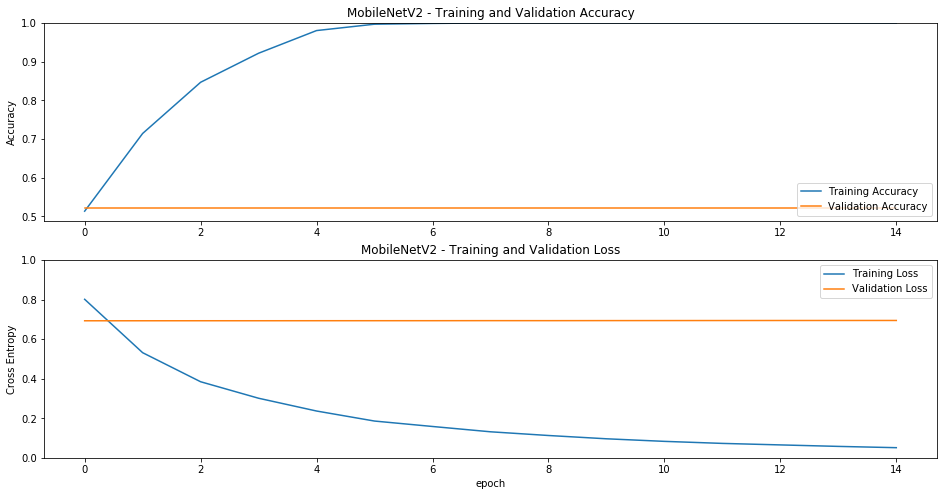

In [60]:
plothistory(history, 'MobileNetV2')

In [61]:
##################################
# Training Keras Application VGG19
##################################
# model = build(VGG19(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights=None, classes=1))
model = transfer(VGG19(weights=None, include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 512)               2359808   
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 513       
Total params: 22,384,705
Trainable params: 22,384,705
Non-trainable params: 0
_________________________________________________________________
Model: "vgg19"
_________________________________________________________________
Layer (type)              

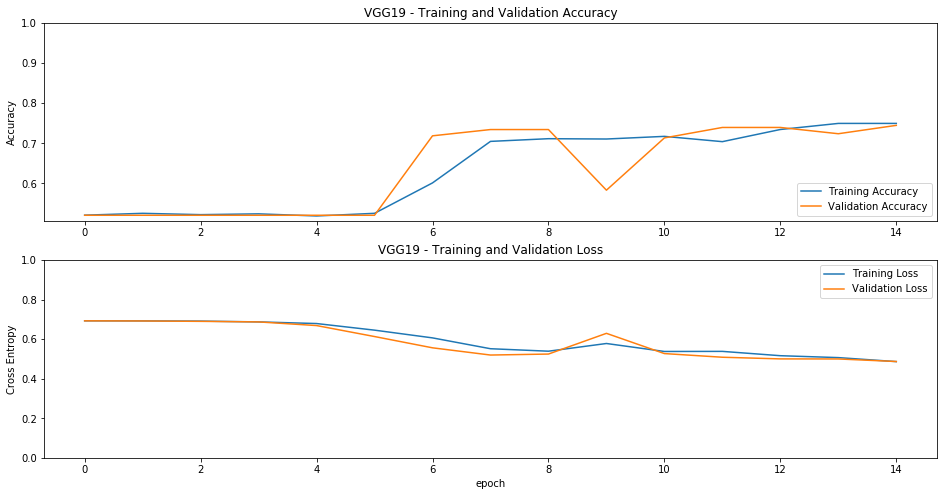

In [62]:
plothistory(history, 'VGG19')

In [63]:
########################################
# Training Keras Application InceptionV3
########################################
# model = build(InceptionV3(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights=None, classes=1))
model = transfer(InceptionV3(weights=None, include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 513       
Total params: 25,998,113
Trainable params: 25,963,681
Non-trainable params: 34,432
_________________________________________________________________
Model: "inception_v3"
________________________________________________________________________________

  ...
    to  
  ['...']
Train for 24 steps, validate for 3 steps
Epoch 1/15
24/24 [==============================] - 12s 502ms/step - loss: 0.7512 - accuracy: 0.5244 - val_loss: 0.6931 - val_accuracy: 0.5208
Epoch 2/15
24/24 [==============================] - 4s 183ms/step - loss: 0.2235 - accuracy: 0.9598 - val_loss: 0.6937 - val_accuracy: 0.5208
Epoch 3/15
24/24 [==============================] - 4s 185ms/step - loss: 0.0734 - accuracy: 1.0000 - val_loss: 0.6937 - val_accuracy: 0.5208
Epoch 4/15
24/24 [==============================] - 4s 184ms/step - loss: 0.0352 - accuracy: 1.0000 - val_loss: 0.6966 - val_accuracy: 0.5208
Epoch 5/15
24/24 [==============================] - 4s 183ms/step - loss: 0.0216 - accuracy: 1.0000 - val_loss: 0.7025 - val_accuracy: 0.5208
Epoch 6/15
24/24 [==============================] - 4s 185ms/step - loss: 0.0152 - accuracy: 1.0000 - val_loss: 0.7076 - val_accuracy: 0.5208
Epoch 7/15
24/24 [==============================] - 4s 185ms/step - loss: 0.0119 

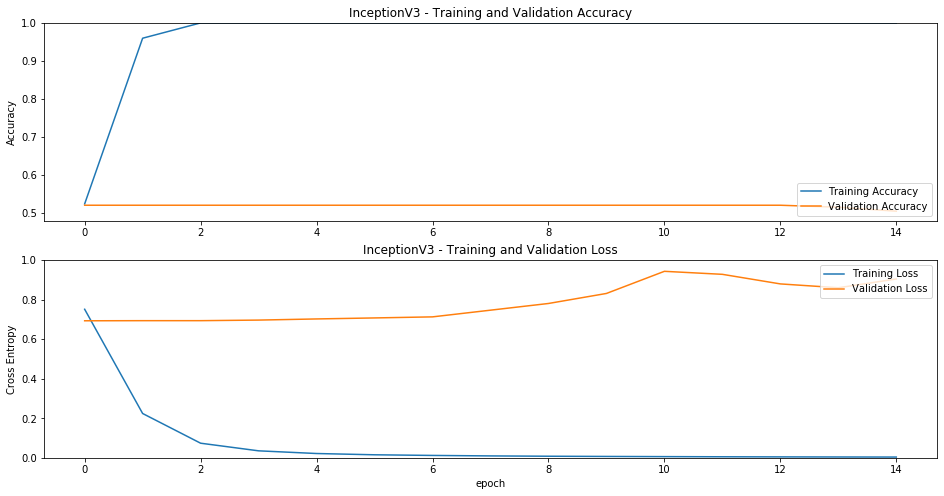

In [64]:
plothistory(history, 'InceptionV3')